#### PRELIMINARIES

First we import the libraries we will need, and the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Import data

In [2]:
data = pd.read_csv('Table2_Hunt_2013_edit.csv')
data = data.drop(['Random 1', 'Random 2', 'Gross pay transform'],  axis=1)

In [3]:
data

,Gross pay,Phi-h,Position,Pressure,Production
0,0.1,0.5,2.1,19,15.10
1,1.0,4.0,1.1,16,21.30
2,1.9,19.0,1.0,14,22.75
3,3.1,21.7,2.1,17,15.72
4,4.1,24.6,2.9,11,7.71
5,4.9,39.2,1.1,12,22.67
6,5.9,23.6,2.1,13,18.11
7,7.0,63.0,2.0,13,24.30
8,8.1,72.9,2.9,14,24.04
9,8.9,35.6,2.8,16,25.11


A quick summary of the data (count row) shows there are no missing data points.

In [4]:
data.describe()

,Gross pay,Phi-h,Position,Pressure,Production
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,9.823810,68.880952,1.885714,15.285714,33.428571
std,5.948521,45.167894,0.708721,2.759400,15.141909
min,0.100000,0.500000,1.000000,10.000000,7.710000
25%,4.900000,24.600000,1.100000,14.000000,22.670000
50%,10.000000,72.900000,2.000000,16.000000,36.420000
75%,15.100000,100.000000,2.200000,17.000000,44.200000
max,19.100000,160.000000,2.900000,20.000000,59.200000


We can also explicitly test to ensure data does not have no missing measurements.

In [5]:
data.isnull().values.any()

False

### Visual inspection of outliers

In [6]:
# determine best fit line
# http://stackoverflow.com/a/23377802/1034648

par = np.polyfit(data['Gross pay'], data['Production'], 1, full=True)
slope=par[0][0]
intercept=par[0][1]
xl = [np.amin(data['Gross pay']), np.amax(data['Gross pay'])]
yl = [slope*xx + intercept  for xx in xl]


In [7]:
# coefficient of determination
variance = np.var(data['Production'])
residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(data['Gross pay'], data['Production'])])
Rsqr = np.round(1-residuals/variance, decimals=2)

# error
yerr = [abs(slope*xx + intercept - yy)  for xx,yy in zip(data['Gross pay'], data['Production'])]

# https://docs.scipy.org/doc/numpy-1.6.0/reference/generated/numpy.var.html
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html


In [8]:
# find outliers

# based on error percentiles
index = np.where(np.array(yerr)> np.percentile(np.array(yerr)[np.array(yerr)> 0], 98))

# based on specific error threshold value
# index = np.where(np.array(yerr)> 5.) 

# Although, the ideal ourtlier should be defined based on a-priori information, e.g. anything above/below a certain value of Gross Pay and/or Production is unrealistic....

In [9]:
cl_data = data.drop(data.index[index])

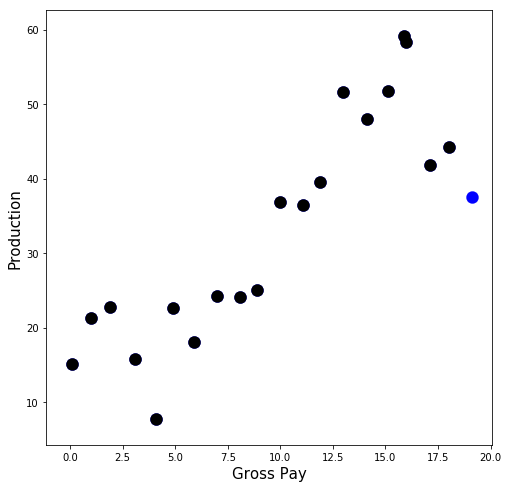

In [10]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Gross Pay', fontsize = '15')
ax.set_ylabel('Production', fontsize = '15')

plt.scatter(data['Gross pay'], data['Production'], c='b', s=150, linewidths=0.15)
plt.scatter(cl_data['Gross pay'], cl_data['Production'], c='k', s=150, linewidths=0.15);


### Effect on best fit and correlation coefficient of removing outliers

In [11]:
# https://gist.github.com/rsnemmen/0eb32832c657c19e4d39

def scatterfit(x,y,a=None,b=None):  
  """  
 Compute the mean deviation of the data about the linear model given if A,B  
 (y=ax+b) provided as arguments. Otherwise, compute the mean deviation about   
 the best-fit line.  
   
 x,y assumed to be np arrays. a,b scalars.  
 Returns the float sd with the mean deviation.  
   
 Author: Rodrigo Nemmen  
  """  
  if a==None:   
  # Performs linear regression  
    a, b, r, p, err = sp.stats.linregress(x,y)  
    
# Std. deviation of an individual measurement (Bevington, eq. 6.15)  
  N=np.size(x)  
  sd=1./(N-2.)* np.sum((y-a*x-b)**2); sd=np.sqrt(sd)  
    
  return sd 

In [12]:
# https://gist.github.com/rsnemmen/f2c03beb391db809c90f

def confband(xd,yd,a,b,conf=0.95,x=None):
  """
Calculates the confidence band of the linear regression model at the desired confidence
level, using analytical methods. The 2sigma confidence interval is 95% sure to contain 
the best-fit regression line. This is not the same as saying it will contain 95% of 
the data points.

Arguments:
- conf: desired confidence level, by default 0.95 (2 sigma)
- xd,yd: data arrays
- a,b: linear fit parameters as in y=ax+b
- x: (optional) array with x values to calculate the confidence band. If none is provided, will
  by default generate 100 points in the original x-range of the data.
  
Returns:
Sequence (lcb,ucb,x) with the arrays holding the lower and upper confidence bands 
corresponding to the [input] x array.

Usage:
>>> lcb,ucb,x=nemmen.confband(all.kp,all.lg,a,b,conf=0.95)
calculates the confidence bands for the given input arrays

>>> plt.fill_between(x, lcb, ucb, alpha=0.3, facecolor='gray')
plots a shaded area containing the confidence band

References:
1. http://en.wikipedia.org/wiki/Simple_linear_regression, see Section Confidence intervals
2. http://www.weibull.com/DOEWeb/confidence_intervals_in_simple_linear_regression.htm

Author: Rodrigo Nemmen
v1 Dec. 2011
v2 Jun. 2012: corrected bug in computing dy
  """
  alpha=1.-conf	# significance
  n=xd.size	# data sample size
 
  if x==None: x=np.linspace(xd.min(),xd.max(),100)
 
  # Predicted values (best-fit model)
  y=a*x+b
 
  # Auxiliary definitions
  sd=scatterfit(xd,yd,a,b)	# Scatter of data about the model
  sxd=np.sum((xd-xd.mean())**2)
  sx=(x-xd.mean())**2	# array
 
  # Quantile of Student's t distribution for p=1-alpha/2
  q=sp.stats.t.ppf(1.-alpha/2.,n-2)
 
  # Confidence band
  dy=q*sd*np.sqrt( 1./n + sx/sxd )
  ucb=y+dy # Upper confidence band
  lcb=y-dy # Lower confidence band
 
  return lcb,ucb,x

In [13]:
# http://astropython.blogspot.ca/2011_12_01_archive.html

# Linear fit  
slope, intercept, cc, ps, err = sp.stats.linregress(data['Gross pay'], data['Production'])  
   
# Generates arrays with the fit  
x=np.linspace(np.amin(data['Gross pay']), np.amax(data['Gross pay']),100)  
y=slope*x+intercept  
   
# Calculates the 2 sigma confidence band contours for the fit  
lcb, ucb, xcb=confband(data['Gross pay'], data['Production'], slope, intercept, conf=0.95)  


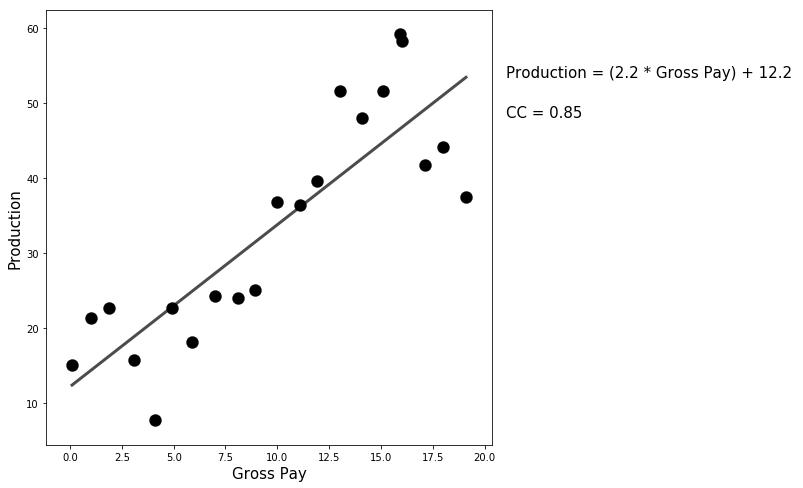

In [14]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Gross Pay', fontsize = '15')
ax.set_ylabel('Production', fontsize = '15')

plt.text(1.1*np.amax(xl),np.amax(yl),'Production = ({0:.1f} * Gross Pay) + {1:.1f} '.format
         (slope, intercept), size=15, color='k')
plt.text(1.1*np.amax(xl), 0.9*np.amax(yl),'CC = {0:.2f} '.format(cc), size=15, color='k')

plt.plot(x,y, 'k', lw = 3, alpha = 0.7) 

plt.scatter(data['Gross pay'], data['Production'], c='k', s=150, linewidths=0.15);


In [15]:
# Linear fit without outlier 
slope1, intercept1, cc1, ps1, err1 = sp.stats.linregress(cl_data['Gross pay'], cl_data['Production'])  
   
# Generates arrays with the fit  
x1=np.linspace(np.amin(cl_data['Gross pay']), np.amax(cl_data['Gross pay']),100)  
y1=slope1*x1+intercept1
   
# Calculates the 2 sigma confidence band contours for the fit  
lcb1, ucb1, xcb1 =confband(cl_data['Gross pay'], cl_data['Production'], slope1, intercept1, conf=0.95) 

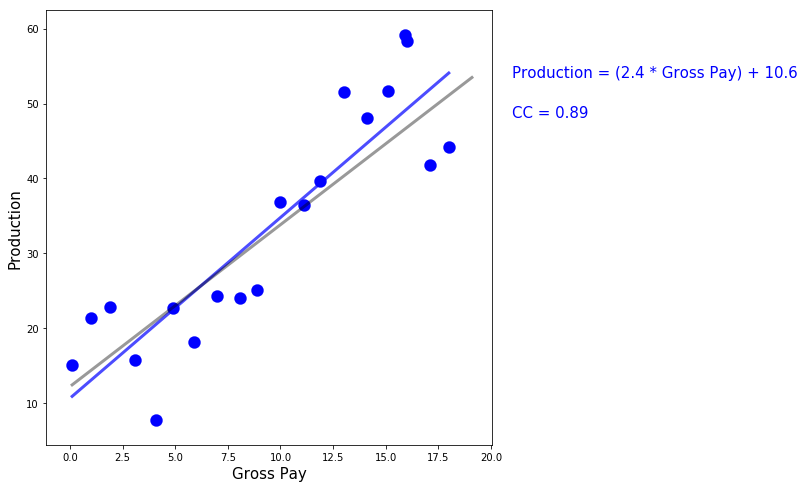

In [16]:
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Gross Pay', fontsize = '15')
ax.set_ylabel('Production', fontsize = '15')

plt.text(1.1*np.amax(xl),np.amax(yl),'Production = ({0:.1f} * Gross Pay) + {1:.1f} '.format
         (slope1, intercept1), size=15, color='b')
plt.text(1.1*np.amax(xl), 0.9*np.amax(yl),'CC = {0:.2f} '.format(cc1), size=15, color='b')

plt.plot(x1,y1, 'b', lw = 3, alpha = 0.7)
plt.plot(x,y, 'k', lw = 3, alpha = 0.4) 

plt.scatter(cl_data['Gross pay'], cl_data['Production'], c='b', s=150, linewidths=0.15);